In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade jax jaxlib flax optax
!pip install -q transformers datasets
!pip install -q imageio[ffmpeg]
!pip install -q Pillow
!pip install -q gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [jax]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [datasets]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 114.6 MB/s eta 0:00:00


In [ ]:
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [tensorflow]


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
import os
from PIL import Image
import imageio
from transformers import CLIPTokenizer


print("JAX Version:", jax.__version__)
print("Available Devices:", jax.devices())
if not jax.devices('tpu'):
    print("Warning: TPU not detected. Check Runtime -> Change runtime type.")
else:
    print(f"TPU detected with {jax.device_count()} devices.")

JAX Version: 0.6.0
Available Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]
TPU detected with 8 devices.


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Proceeding without Drive mount, but saving/loading data/checkpoints will be local to this session.")
    project_dir = '/content/MyTextToGifProject'
    os.makedirs(project_dir, exist_ok=True)

print("\nSetup complete.")

Mounted at /content/drive
Google Drive mounted successfully.

Setup complete.


In [ ]:
#@title Define Paths for Preprocessing

import os
import pandas as pd
import time
import requests
import numpy as np
from PIL import Image
import imageio

# --- Configuration ---
TSV_FILE_PATH = '/content/tgif-v1.0.tsv'


# --- Use Local Colab Storage ---
PREPROCESSED_DATA_DIR = '/content/tgif_preprocessed_local_32px_16f'
PROCESSED_MANIFEST_FILE = os.path.join(PREPROCESSED_DATA_DIR, 'processed_manifest.csv')

IMAGE_SIZE = 32
N_FRAMES = 16
MAX_LENGTH = 77

# Temporary local directory for downloads
TEMP_DOWNLOAD_DIR = '/content/temp_gifs'

# --- Create directories ---
os.makedirs(PREPROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(TEMP_DOWNLOAD_DIR, exist_ok=True)
print(f"Temporary download directory: {TEMP_DOWNLOAD_DIR}")
print(f"Preprocessed data directory (Local Colab Disk): {PREPROCESSED_DATA_DIR}")
print(f"Manifest file path (Local Colab Disk): {PROCESSED_MANIFEST_FILE}")

# --- Initialize Tokenizer ---
try:
    if 'tokenizer' not in globals():
      from transformers import CLIPTokenizer
      tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    print("CLIP Tokenizer loaded.")
except Exception as e:
    print(f"Error loading tokenizer. Make sure transformers is installed and model exists: {e}")

# --- Helper functions (make sure they are defined) ---
def sample_frames_from_path(gif_path, n_frames, image_size):
    """Reads a GIF from path, samples, resizes, normalizes."""
    try:
        reader = imageio.get_reader(gif_path)
        frames_raw = []
        for frame in reader:
            pil_frame = Image.fromarray(frame).convert('RGB')
            frames_raw.append(np.array(pil_frame))
        reader.close()
    except Exception as e:
        # print(f"Error reading GIF {os.path.basename(gif_path)}: {e}")
        return None

    if not frames_raw: return None
    total_frames = len(frames_raw)
    if total_frames == 0: return None

    indices = np.linspace(0, total_frames - 1, n_frames, dtype=int)
    processed_frames = []
    for idx in indices:
        frame = frames_raw[idx]
        pil_img = Image.fromarray(frame)
        resized_img = pil_img.resize((image_size, image_size), Image.Resampling.LANCZOS)
        np_img = np.array(resized_img)
        normalized_img = (np_img / 255.0) * 2.0 - 1.0
        processed_frames.append(normalized_img)

    return np.stack(processed_frames).astype(np.float32)

def preprocess_text_for_saving(text, tokenizer, max_length):
    """Tokenizes text using CLIP tokenizer."""
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="np")
    return inputs['input_ids'][0].astype(np.int32)

print("Helper functions defined/verified.")
print("--- !!! ---")
print("WARNING: Preprocessed data will be saved to the local Colab disk.")
print("This data will be LOST if the runtime restarts.")
print("Save model checkpoints frequently to Google Drive during training.")
print("--- !!! ---")

Temporary download directory: /content/temp_gifs
Preprocessed data directory (Local Colab Disk): /content/tgif_preprocessed_local_32px_16f
Manifest file path (Local Colab Disk): /content/tgif_preprocessed_local_32px_16f/processed_manifest.csv


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


CLIP Tokenizer loaded.
Helper functions defined/verified.
--- !!! ---
This data will be LOST if the runtime restarts.
Save model checkpoints frequently to Google Drive during training.
--- !!! ---


In [ ]:
#@title Load CLIP Text Encoder Model

import jax
import flax.linen as nn
from transformers import CLIPTokenizer, FlaxCLIPTextModelWithProjection
import numpy as np

CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"

# --- Initialize variable BEFORE try/except blocks ---
text_embedding_dim = None # Initialize to None

print(f"Loading CLIP Tokenizer: {CLIP_MODEL_NAME}")
try:

    if 'tokenizer' not in globals():
         print("Error: Tokenizer not found. Please run the preprocessing setup cell first.")
         tokenizer = CLIPTokenizer.from_pretrained(CLIP_MODEL_NAME)
         print("Tokenizer loaded now.")
    else:
        print("Tokenizer already exists.")

    print(f"Loading Flax CLIP Text Model (with Projection): {CLIP_MODEL_NAME}")
    clip_text_model = FlaxCLIPTextModelWithProjection.from_pretrained(CLIP_MODEL_NAME)
    print("Flax CLIP Text Model loaded successfully.")

    # --- Determine text_embedding_dim ---
    try:
        if 'MAX_LENGTH' not in globals():
             raise NameError("MAX_LENGTH not defined. Ensure pipeline setup cell was run.")
        dummy_input_ids = np.array([[tokenizer.eos_token_id] * MAX_LENGTH])
        output = clip_text_model(input_ids=dummy_input_ids)
        text_embedding_dim = output.text_embeds.shape[-1]
        print(f"CLIP text embedding dimension determined: {text_embedding_dim}")
    except Exception as e_inner:
        print(f"Could not determine embedding dimension automatically: {e_inner}")
        text_embedding_dim = 512
        print(f"Using fallback text embedding dimension: {text_embedding_dim}")

except Exception as e_outer:
    print(f"Error during CLIP model loading or dimension determination: {e_outer}")
    # --- Assign directly only if still None ---
    if text_embedding_dim is None:
         text_embedding_dim = 512
         print(f"Using placeholder text embedding dimension due to outer error: {text_embedding_dim}")


if text_embedding_dim is None:
    print("ERROR: text_embedding_dim could not be determined or set.")
else:
    print(f"Final text_embedding_dim value: {text_embedding_dim}")

Loading CLIP Tokenizer: openai/clip-vit-base-patch32
Tokenizer already exists.
Loading Flax CLIP Text Model (with Projection): openai/clip-vit-base-patch32


flax_model.msgpack:   0%|          | 0.00/605M [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing FlaxCLIPTextModelWithProjection: {('vision_model', 'encoder', 'layers', '9', 'mlp', 'fc1', 'kernel'), ('vision_model', 'encoder', 'layers', '5', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '2', 'self_attn', 'out_proj', 'bias'), ('vision_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '3', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '4', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '2', 'layer_norm2', 'bias'), ('vision_model', 'encoder', 'layers', '10', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '6', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', 

Flax CLIP Text Model loaded successfully.
CLIP text embedding dimension determined: 512
Final text_embedding_dim value: 512


In [ ]:
#@title Load TGIF TSV File and Create IDs

import csv
import pandas as pd

annotations_to_process = []

print(f"Attempting to load TSV from: {TSV_FILE_PATH}")

try:
    with open(TSV_FILE_PATH, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')

        for i, row in enumerate(reader):
            if len(row) == 2:
                url, description = row

                if isinstance(url, str) and url.lower().startswith('http') and url.lower().endswith('.gif') and isinstance(description, str) and description.strip():

                    unique_id = f"item_{i:07d}"
                    annotations_to_process.append({
                        'id': unique_id,
                        'url': url,
                        'text': description.strip()
                    })
                else:
                    print(f"Skipping row {i+1} due to invalid format/content: {row}") # Log invalid rows
            else:
                 print(f"Skipping row {i+1} due to incorrect number of columns ({len(row)}): {row}")

    print(f"Loaded {len(annotations_to_process)} valid annotations from {TSV_FILE_PATH}")
    if annotations_to_process:
        print("Sample of loaded data structure:", annotations_to_process[0])
    else:
        print("Warning: No valid annotations were loaded. Check TSV path and format.")

except FileNotFoundError:
    print(f"ERROR: TSV file not found at {TSV_FILE_PATH}. Please upload it or correct the path.")
except Exception as e:
    print(f"Error reading TSV file: {e}")

Attempting to load TSV from: /content/tgif-v1.0.tsv
Loaded 125782 valid annotations from /content/tgif-v1.0.tsv
Sample of loaded data structure: {'id': 'item_0000000', 'url': 'https://38.media.tumblr.com/9f6c25cc350f12aa74a7dc386a5c4985/tumblr_mevmyaKtDf1rgvhr8o1_500.gif', 'text': 'a man is glaring, and someone with sunglasses appears.'}


In [ ]:
if annotations_to_process:
    print("Checking first item structure in annotations_to_process:")
    print(annotations_to_process[0])
    if 'id' in annotations_to_process[0]:
        print("'id' key found. Looks good!")
    else:
        print("ERROR: 'id' key is MISSING from the loaded annotations!")
elif 'annotations_to_process' in globals():
     print("annotations_to_process list exists but is empty.")
else:
     print("annotations_to_process list does not exist.")

Checking first item structure in annotations_to_process:
{'id': 'item_0000000', 'url': 'https://38.media.tumblr.com/9f6c25cc350f12aa74a7dc386a5c4985/tumblr_mevmyaKtDf1rgvhr8o1_500.gif', 'text': 'a man is glaring, and someone with sunglasses appears.'}
'id' key found. Looks good!


In [ ]:
#@title Run Preprocessing Loop (Download, Process, Save Locally)

import pandas as pd

processed_list = []
processed_ids = set()
failed_downloads = []
failed_processing = []

# --- Optional: Load existing manifest from local path to resume ---
resume_run = True
if resume_run and os.path.exists(PROCESSED_MANIFEST_FILE):
    print(f"Found existing manifest: {PROCESSED_MANIFEST_FILE}. Resuming...")
    try:
        existing_df = pd.read_csv(PROCESSED_MANIFEST_FILE)
        processed_ids = set(existing_df['id'])
        processed_list = existing_df.to_dict('records')
        print(f"Loaded {len(processed_ids)} previously processed IDs.")
    except Exception as e:
        print(f"Warning: Could not load or parse existing manifest. Starting fresh. Error: {e}")
        processed_list = []
        processed_ids = set()


# --- Iterate and process ---
start_time = time.time()
process_limit = 500
save_interval = 500

headers = {'User-Agent': 'Mozilla/5.0'}


if 'annotations_to_process' not in globals() or not annotations_to_process:
     print("ERROR: annotations_to_process not found or empty. Please load the TSV file first.")
else:
    print(f"Starting preprocessing for {len(annotations_to_process)} items...")
    for i, item in enumerate(annotations_to_process):
        item_id = item['id']
        url = item['url']
        description = item['text']

        if process_limit is not None and i >= process_limit:
          print(f"Reached processing limit of {process_limit}. Stopping.")
          break

        if item_id in processed_ids:
            continue

        # --- 1. Download ---
        temp_gif_path = os.path.join(TEMP_DOWNLOAD_DIR, f"{item_id}.gif")
        download_success = False
        try:
            response = requests.get(url, headers=headers, timeout=20, stream=True)
            response.raise_for_status()
            with open(temp_gif_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            download_success = True
        except requests.exceptions.RequestException as e:
            failed_downloads.append({'id': item_id, 'url': url, 'error': str(e)})
        except Exception as e:
            failed_downloads.append({'id': item_id, 'url': url, 'error': f"Unexpected: {str(e)}"})

        if not download_success:
            if os.path.exists(temp_gif_path): os.remove(temp_gif_path)
            continue

        # --- 2. Process GIF Frames ---
        frames = sample_frames_from_path(temp_gif_path, N_FRAMES, IMAGE_SIZE)

        # --- 3. Process Text ---
        tokens = preprocess_text_for_saving(description, tokenizer, MAX_LENGTH)

        # --- 4. Save to Local Colab Disk ---
        if frames is not None:
            # Define local paths for .npy files
            frames_save_path = os.path.join(PREPROCESSED_DATA_DIR, f"{item_id}_frames.npy")
            tokens_save_path = os.path.join(PREPROCESSED_DATA_DIR, f"{item_id}_tokens.npy")

            try:
                # Use standard np.save for local paths
                np.save(frames_save_path, frames)
                np.save(tokens_save_path, tokens)

                # Record success
                processed_list.append({
                    'id': item_id,
                    'frames_path': frames_save_path,
                    'tokens_path': tokens_save_path,
                    'original_text': description
                })
                processed_ids.add(item_id)

            except Exception as e:
                print(f"ERROR saving files locally for {item_id}: {e}")
                failed_processing.append({'id': item_id, 'url': url, 'error': f"Saving failed: {str(e)}"})
                # Clean up potentially corrupted local files
                if os.path.exists(frames_save_path): os.remove(frames_save_path)
                if os.path.exists(tokens_save_path): os.remove(tokens_save_path)
                if item_id in processed_ids: processed_ids.remove(item_id)

        else:
            failed_processing.append({'id': item_id, 'url': url, 'error': "Frame sampling returned None"})

        # --- 5. Clean up downloaded GIF ---
        if os.path.exists(temp_gif_path):
            os.remove(temp_gif_path)

        # --- Progress Update & Periodic Manifest Save ---
        processed_count = len(processed_ids)
        if processed_count > 0 and processed_count % save_interval == 0:
            elapsed_time = time.time() - start_time
            total_items = len(annotations_to_process) if process_limit is None else process_limit
            if processed_count > 0 and total_items > 0:
                eta_seconds = (elapsed_time / processed_count) * (total_items - processed_count)
                eta_minutes = eta_seconds / 60
                print(f"Processed {processed_count}/{total_items} items... Time: {elapsed_time:.2f}s (ETA: {eta_minutes:.1f} min)")
            else:
                 print(f"Processed {processed_count}/{total_items} items... Time: {elapsed_time:.2f}s")

            # Save backup manifest locally
            backup_manifest_path = os.path.join(PREPROCESSED_DATA_DIR, 'processed_manifest_backup.csv')
            temp_df = pd.DataFrame(processed_list)
            try:
              # Use standard pandas to write local CSV
              temp_df.to_csv(backup_manifest_path, index=False)
            except Exception as e:
              print(f"Warning: Failed to save manifest backup: {e}")


# --- Final Save of Manifest ---
end_time = time.time()
print(f"\nPreprocessing finished. Total time: {end_time - start_time:.2f} seconds.")
print(f"Successfully processed: {len(processed_ids)}")
print(f"Failed downloads: {len(failed_downloads)}")
print(f"Failed processing/saving: {len(failed_processing)}")

if processed_list:
    final_df = pd.DataFrame(processed_list)
    try:
        final_df.to_csv(PROCESSED_MANIFEST_FILE, index=False)
        print(f"Final manifest saved locally to: {PROCESSED_MANIFEST_FILE}")
        print(final_df.head())
    except Exception as e:
        print(f"ERROR: Failed to save final manifest: {e}")
else:
    print("No items were successfully processed and saved.")


Starting preprocessing for 14124 items...
Processed 500/500 items... Time: 200.15s (ETA: 0.0 min)
Reached processing limit of 500. Stopping.

Preprocessing finished. Total time: 200.16 seconds.
Successfully processed: 500
Failed downloads: 0
Failed processing/saving: 0
Final manifest saved locally to: /content/tgif_preprocessed_local_32px_16f/processed_manifest.csv
             id                                        frames_path  \
0  item_0000000  /content/tgif_preprocessed_local_32px_16f/item...   
1  item_0000001  /content/tgif_preprocessed_local_32px_16f/item...   
2  item_0000002  /content/tgif_preprocessed_local_32px_16f/item...   
3  item_0000003  /content/tgif_preprocessed_local_32px_16f/item...   
4  item_0000004  /content/tgif_preprocessed_local_32px_16f/item...   

                                         tokens_path  \
0  /content/tgif_preprocessed_local_32px_16f/item...   
1  /content/tgif_preprocessed_local_32px_16f/item...   
2  /content/tgif_preprocessed_local_32px_16

In [ ]:
#@title Create tf.data Pipeline

import tensorflow as tf
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
import os
import time

try:
    tf.config.set_visible_devices([], 'GPU')
    print("TensorFlow GPU visibility disabled.")
except Exception as e:
    print(f"Could not disable TensorFlow GPU visibility: {e}")


IMAGE_SIZE = 32
N_FRAMES = 16
MAX_LENGTH = 77

# --- Local Path to Manifest ---

PREPROCESSED_DATA_DIR = '/content/tgif_preprocessed_local_32px_16f'
PROCESSED_MANIFEST_FILE = os.path.join(PREPROCESSED_DATA_DIR, 'processed_manifest.csv')
# --- Batching and Shuffling Parameters ---
BATCH_SIZE_PER_DEVICE = 4
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_DEVICE * jax.device_count()
BUFFER_SIZE = 1000

print(f"Targeting Global Batch Size: {GLOBAL_BATCH_SIZE} ({BATCH_SIZE_PER_DEVICE} per device)")
print(f"Loading data manifest from local path: {PROCESSED_MANIFEST_FILE}")

# --- Load the processed manifest from local disk ---
manifest_list = []
try:
    if not os.path.exists(PROCESSED_MANIFEST_FILE):
         raise FileNotFoundError(f"Manifest file not found at {PROCESSED_MANIFEST_FILE}")
    manifest_df = pd.read_csv(PROCESSED_MANIFEST_FILE)

    if not all(col in manifest_df.columns for col in ['frames_path', 'tokens_path']):
        raise ValueError("Manifest CSV missing required columns: 'frames_path' and 'tokens_path'")
    manifest_list = manifest_df.to_dict('records')
    print(f"Loaded manifest with {len(manifest_list)} processed items.")
    if not manifest_list:
        print("Warning: Manifest file loaded but is empty.")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please ensure the preprocessing step writing locally completed successfully and the path is correct.")
except Exception as e:
    print(f"Error loading or parsing processed manifest: {e}")
    manifest_list = []

# --- Data Generator using Local Preprocessed Files ---
def preprocessed_data_generator():
    """Yields preprocessed (tokens, frames) pairs by reading local .npy files."""
    if not manifest_list:
         print("Generator stopping: Manifest list is empty.")
         raise StopIteration

    indices = np.arange(len(manifest_list))
    np.random.shuffle(indices)
    print(f"Data Generator: Starting epoch with {len(indices)} shuffled indices.")

    files_loaded = 0
    files_failed = 0
    start_time = time.time()

    for i in indices:
        item = manifest_list[i]
        frames_path = item['frames_path']
        tokens_path = item['tokens_path']

        try:
            tokens = np.load(tokens_path)
            frames = np.load(frames_path)

            # Basic shape and type check
            if tokens.shape == (MAX_LENGTH,) and frames.shape == (N_FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3):
                 yield {'input_ids': tokens.astype(np.int32), 'pixel_values': frames.astype(np.float32)}
                 files_loaded += 1
            else:
                 files_failed += 1


        except FileNotFoundError:
             files_failed += 1
        except Exception as e:
            print(f"Warning: Error loading local data for item {item.get('id', 'N/A')} (Paths: {tokens_path}, {frames_path}). Error: {e}. Skipping.")
            files_failed += 1


    print(f"Data Generator: Epoch finished. Loaded {files_loaded}, Failed {files_failed}.")


# Define output signature for tf.data
output_signature = {
    'input_ids': tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32),
    'pixel_values': tf.TensorSpec(shape=(N_FRAMES, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32)
}

# --- Create the tf.data.Dataset ---
if manifest_list:
    print("Creating tf.data.Dataset from generator...")
    dataset = tf.data.Dataset.from_generator(
        preprocessed_data_generator,
        output_signature=output_signature
    )

    print("Applying dataset transformations (shuffle, repeat, batch, prefetch)...")
    # --- Apply transformations ---
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.repeat()

    # Batch the data. drop_remainder=True is crucial for TPUs requiring fixed batch sizes per device.
    dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)

    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    print("Dataset transformations applied.")

    # --- Function to shard batch for JAX pmap ---
    def shard_batch(batch):
        """Reshapes and distributes batch across JAX devices."""
        batch = jax.tree_util.tree_map(lambda x: jnp.array(x), batch)
        num_devices = jax.local_device_count()

        return jax.tree_util.tree_map(
            lambda x: x.reshape((num_devices, -1) + x.shape[1:]), batch
        )

    # --- Convert TF dataset to NumPy iterator and test ---
    print("\nConverting dataset to NumPy iterator for JAX...")
    numpy_iterator = tfds.as_numpy(dataset)

    print("Testing the data pipeline by fetching one batch...")
    start_fetch_time = time.time()
    try:

        example_batch = next(iter(numpy_iterator))
        fetch_time = time.time() - start_fetch_time
        print(f"Successfully fetched one batch in {fetch_time:.2f} seconds.")


        sharded_batch = shard_batch(example_batch)
        print("Batch sharded successfully.")

        print("\n--- Batch Shapes ---")
        print("Original batch shapes (Global Batch):")
        jax.tree_map(lambda x: print(f"  {x.shape}, {x.dtype}"), example_batch)

        print("\nSharded batch shapes (Per Device):")
        jax.tree_map(lambda x: print(f"  {x.shape}, {x.dtype}"), sharded_batch)

        print("\nData pipeline setup and test successful!")

    except StopIteration:
         print("\nERROR: The data generator did not yield any data even after creating the dataset.")
         print("This likely means the manifest was empty OR all .npy files failed to load during the first attempt.")
         print("Check the generator logs and the integrity of the preprocessed files.")
    except Exception as e:
        print(f"\nERROR during pipeline testing (fetching/sharding batch): {e}")
        import traceback
        traceback.print_exc()
        print("Check manifest file path, .npy file integrity/paths, batch sizes, and sharding logic.")

else:
    print("\nSkipping dataset creation and testing because the manifest failed to load or was empty.")
    print("Please ensure the preprocessing step ran correctly and created a non-empty manifest file.")

TensorFlow GPU visibility disabled.
Targeting Global Batch Size: 32 (4 per device)
Loading data manifest from local path: /content/tgif_preprocessed_local_32px_16f/processed_manifest.csv
ERROR: Manifest file not found at /content/tgif_preprocessed_local_32px_16f/processed_manifest.csv
Please ensure the preprocessing step writing locally completed successfully and the path is correct.

Skipping dataset creation and testing because the manifest failed to load or was empty.
Please ensure the preprocessing step ran correctly and created a non-empty manifest file.


In [ ]:
#@title Define U-Net Components - v8

import jax.numpy as jnp
import flax.linen as nn
import math
from typing import Sequence, Optional, Tuple, Union, Any
import jax
import einops

if 'einops' not in globals():
    print("Installing einops...")
    !pip install -q einops
    import einops

if 'text_embedding_dim' not in globals(): raise NameError("...")
if not isinstance(text_embedding_dim, int): raise TypeError("...")

# --- Config ---
unet_dim = 64
unet_dim_mults: Tuple[int, ...] = (1, 2, 4)
unet_num_resnet_blocks = 2
unet_attn_resolution_factors: Tuple[int, ...] = (2, 4)
unet_resnet_groups = 32
time_emb_mlp_dim = unet_dim * 4

def normalization(num_groups: int = unet_resnet_groups):
    assert isinstance(num_groups, int) and num_groups > 0, f"Invalid num_groups ({num_groups})"
    return nn.GroupNorm(num_groups=num_groups, epsilon=1e-5)

class SinusoidalPosEmb(nn.Module):
    dim: int
    @nn.compact
    def __call__(self, time):
        # ... implementation ...
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = jnp.concatenate([jnp.sin(embeddings), jnp.cos(embeddings)], axis=-1)
        if self.dim % 2 == 1:
             embeddings = jnp.pad(embeddings, [(0,0), (0,1)])
        return embeddings

class ResnetBlock3D(nn.Module):
    out_channels: int
    groups: int
    time_emb_dim: Optional[int] = None
    text_emb_dim: Optional[int] = None
    dropout_rate: float = 0.1
    @nn.compact
    def __call__(self, x, t_emb=None, text_emb=None, *, train: bool):
        input_channels = x.shape[-1]
        hidden_channels = self.out_channels
        h = normalization(self.groups)(x)
        h = nn.silu(h)
        h = nn.Conv(features=hidden_channels, kernel_size=(3, 3, 3), padding='SAME')(h)
        if t_emb is not None and self.time_emb_dim is not None:
            time_proj = nn.silu(nn.Dense(features=hidden_channels, name='time_proj')(t_emb))
            h = h + time_proj[:, None, None, None, :]
        if text_emb is not None and self.text_emb_dim is not None:
             text_proj = nn.silu(nn.Dense(features=hidden_channels, name='text_proj')(text_emb))
             h = h + text_proj[:, None, None, None, :]
        h = normalization(self.groups)(h)
        h = nn.silu(h)
        h = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(h)
        h = nn.Conv(features=self.out_channels, kernel_size=(3, 3, 3), padding='SAME')(h)
        if input_channels != self.out_channels:
            x_res = nn.Conv(features=self.out_channels, kernel_size=(1, 1, 1))(x)
        else:
            x_res = x
        return h + x_res


class FactorizedAttentionBlock(nn.Module):
    groups: int
    num_heads: int = 8
    dropout_rate: float = 0.0
    @nn.compact
    def __call__(self, x, context=None, *, train: bool):
        # ... implementation ...
        batch_size, num_frames, height, width, channels = x.shape
        residual = x
        head_dim = channels // self.num_heads
        if head_dim == 0: head_dim = 1
        inner_dim = self.num_heads * head_dim
        h = normalization(self.groups)(x)
        # --- 1. Spatial Attention ---
        h_spatial = einops.rearrange(h, 'b f h w c -> (b f) h w c')
        h_spatial = einops.rearrange(h_spatial, 'bf h w c -> bf (h w) c')
        to_qkv_spatial = nn.Dense(features=inner_dim * 3, name='to_qkv_spatial', use_bias=False)
        qkv_spatial = to_qkv_spatial(h_spatial)
        q_s, k_s, v_s = jnp.array_split(qkv_spatial, 3, axis=-1)
        spatial_attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, dropout_rate=self.dropout_rate, deterministic=not train, use_bias=False, name='spatial_attn')
        attn_output_spatial = spatial_attn(inputs_q=q_s, inputs_kv=v_s)
        to_out_spatial = nn.Dense(features=channels, name='to_out_spatial')
        attn_output_spatial = to_out_spatial(attn_output_spatial)
        attn_output_spatial = einops.rearrange(attn_output_spatial, 'bf (h w) c -> bf h w c', h=height, w=width)
        h = einops.rearrange(attn_output_spatial, '(b f) h w c -> b f h w c', b=batch_size, f=num_frames)
        # --- 2. Temporal Attention ---
        h_temporal = einops.rearrange(h, 'b f h w c -> (b h w) f c')
        to_qkv_temporal = nn.Dense(features=inner_dim * 3, name='to_qkv_temporal', use_bias=False)
        qkv_temporal = to_qkv_temporal(h_temporal)
        q_t, k_t, v_t = jnp.array_split(qkv_temporal, 3, axis=-1)
        temporal_attn = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, dropout_rate=self.dropout_rate, deterministic=not train, use_bias=False, name='temporal_attn')
        attn_output_temporal = temporal_attn(inputs_q=q_t, inputs_kv=v_t)
        to_out_temporal = nn.Dense(features=channels, name='to_out_temporal')
        attn_output_temporal = to_out_temporal(attn_output_temporal)
        attn_output_temporal = einops.rearrange(attn_output_temporal, '(b h w) f c -> b f h w c', b=batch_size, h=height, w=width)
        return attn_output_temporal + residual

class Downsample(nn.Module):
    features: int
    @nn.compact
    def __call__(self, x): return nn.Conv(features=self.features, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='SAME')(x)
class Upsample(nn.Module):
    features: int
    @nn.compact
    def __call__(self, x): return nn.ConvTranspose(features=self.features, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='SAME')(x)

# --- Main U-Net Model ---
class UNetConditional3D(nn.Module):
    dim: int = unet_dim
    dim_mults: Tuple[int, ...] = unet_dim_mults
    num_resnet_blocks: int = unet_num_resnet_blocks
    attn_resolution_factors: Tuple[int, ...] = unet_attn_resolution_factors
    resnet_groups: int = unet_resnet_groups
    out_dim: Optional[int] = None
    time_emb_mlp_dim: int = time_emb_mlp_dim
    text_emb_dim: int = text_embedding_dim
    dropout_rate: float = 0.1

    @nn.compact
    def __call__(self, x, time, text_embedding, *, train: bool):
        assert x.ndim == 5, f"Input x must be 5D (B, F, H, W, C), got {x.ndim}"
        assert text_embedding.shape[-1] == self.text_emb_dim, \
               f"Input text_embedding dim ({text_embedding.shape[-1]}) doesn't match model's expected dim ({self.text_emb_dim})"

        channels = x.shape[-1]
        out_dim = self.out_dim if self.out_dim is not None else channels
        t_emb = SinusoidalPosEmb(dim=self.dim)(time)
        t_emb = nn.Dense(features=self.time_emb_mlp_dim, name='time_mlp_1')(t_emb)
        t_emb = nn.silu(t_emb)
        t_emb = nn.Dense(features=self.time_emb_mlp_dim, name='time_mlp_2')(t_emb)

        # --- Refactored Skip Logic ---
        h = nn.Conv(features=self.dim, kernel_size=(3, 3, 3), padding='SAME', name='init_conv')(x)
        hs = []

        # Downsampling
        current_res_factor = 1
        for i, mult in enumerate(self.dim_mults):
            features = self.dim * mult
            for j in range(self.num_resnet_blocks):
                h = ResnetBlock3D(
                    out_channels=features,
                    time_emb_dim=self.time_emb_mlp_dim,
                    text_emb_dim=self.text_emb_dim,
                    groups=self.resnet_groups,
                    dropout_rate=self.dropout_rate,
                    name=f'down_{i}_res_{j}'
                )(h, t_emb, text_embedding, train=train)
                if current_res_factor in self.attn_resolution_factors:
                    h = FactorizedAttentionBlock(
                        num_heads=8,
                        groups=self.resnet_groups,
                        name=f'down_{i}_attn_{j}',
                        dropout_rate=self.dropout_rate
                    )(h, context=None, train=train)

            hs.append(h)

            if i < len(self.dim_mults) - 1:
                h = Downsample(features=features, name=f'down_{i}_downsample')(h)
                current_res_factor *= 2


        # Bottleneck
        mid_features = features
        h = ResnetBlock3D(
             out_channels=mid_features, time_emb_dim=self.time_emb_mlp_dim, text_emb_dim=self.text_emb_dim,
             groups=self.resnet_groups, dropout_rate=self.dropout_rate, name='mid_res_1'
            )(h, t_emb, text_embedding, train=train)
        h = FactorizedAttentionBlock(num_heads=8, groups=self.resnet_groups, name='mid_attn', dropout_rate=self.dropout_rate)(h, context=None, train=train)
        h = ResnetBlock3D(
            out_channels=mid_features, time_emb_dim=self.time_emb_mlp_dim, text_emb_dim=self.text_emb_dim,
            groups=self.resnet_groups, dropout_rate=self.dropout_rate, name='mid_res_2'
            )(h, t_emb, text_embedding, train=train)

        # Upsampling
        for i, mult in reversed(list(enumerate(self.dim_mults))):
            features = self.dim * mult

            # Upsample if not the first upsampling level
            if i < len(self.dim_mults) - 1:
                h = Upsample(features=features, name=f'up_{i}_upsample')(h)
                current_res_factor //= 2

            skip_h = hs.pop()
            h = jnp.concatenate([h, skip_h], axis=-1)

            # Apply ResNet blocks for this level
            for j in range(self.num_resnet_blocks):
                 h = ResnetBlock3D(
                     out_channels=features,
                     time_emb_dim=self.time_emb_mlp_dim,
                     text_emb_dim=self.text_emb_dim,
                     groups=self.resnet_groups,
                     dropout_rate=self.dropout_rate,
                     name=f'up_{i}_res_{j}'
                 )(h, t_emb, text_embedding, train=train)
                 if current_res_factor in self.attn_resolution_factors:
                     h = FactorizedAttentionBlock(
                         num_heads=8,
                         groups=self.resnet_groups,
                         name=f'up_{i}_attn_{j}',
                         dropout_rate=self.dropout_rate
                     )(h, context=None, train=train)



        assert not hs, f"Skip connections remaining after upsampling path: {len(hs)}"

        # Final Layers
        h = normalization(self.resnet_groups)(h)
        h = nn.silu(h)
        output_noise = nn.Conv(features=out_dim, kernel_size=(1, 1, 1), name='final_conv')(h)
        return output_noise

# --- Quick Test (Initialization) ---
print("\n--- Testing Model Initialization (32px Input) ---")
key = jax.random.PRNGKey(0)
# ... (dummy data setup) ...
dummy_batch_size=2; dummy_frames=N_FRAMES; dummy_height=32; dummy_width=32; dummy_channels=3; dummy_text_emb_dim_test=text_embedding_dim
dummy_x = jnp.ones((dummy_batch_size, dummy_frames, dummy_height, dummy_width, dummy_channels), dtype=jnp.float32)
dummy_time = jnp.ones((dummy_batch_size,), dtype=jnp.int32)
dummy_text_emb = jnp.ones((dummy_batch_size, dummy_text_emb_dim_test), dtype=jnp.float32)


# Instantiate the model
print(f"Instantiating UNet with config:")
unet_model = UNetConditional3D(
    dim=unet_dim, dim_mults=unet_dim_mults, num_resnet_blocks=unet_num_resnet_blocks,
    attn_resolution_factors=unet_attn_resolution_factors, resnet_groups=unet_resnet_groups,
    out_dim=dummy_channels, time_emb_mlp_dim=time_emb_mlp_dim,
    text_emb_dim=text_embedding_dim, dropout_rate=0.1
)

# Initialize parameters
print("Initializing U-Net parameters...")
try:
    params = unet_model.init(key, dummy_x, dummy_time, dummy_text_emb, train=False)['params']
    print("U-Net initialization successful.")
    print("Testing U-Net forward pass...")
    output = unet_model.apply({'params': params}, dummy_x, dummy_time, dummy_text_emb, train=False)
    print(f"Output shape: {output.shape}, dtype: {output.dtype}")
    if output.shape == dummy_x.shape: print("Output shape matches input shape. Looks good!")
    else: print(f"WARNING: Output shape {output.shape} does not match input shape {dummy_x.shape}")
    num_params = sum(x.size for x in jax.tree_util.tree_leaves(params))
    print(f"Total number of parameters in U-Net: {num_params:,}")
except Exception as e:
    print(f"\nERROR during U-Net initialization or forward pass: {e}")
    import traceback
    traceback.print_exc()


--- Testing Model Initialization (32px Input) ---
Instantiating UNet with config:
Initializing U-Net parameters...
U-Net initialization successful.
Testing U-Net forward pass...
Output shape: (2, 16, 32, 32, 3), dtype: float32
Output shape matches input shape. Looks good!
Total number of parameters in U-Net: 36,921,987


In [ ]:
#@title Define Diffusion Schedule, Sampling Functions, and Loss

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.core import FrozenDict

# --- Diffusion Hyperparameters ---
NUM_DIFFUSION_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

# --- Noise Schedule Calculation ---

def linear_beta_schedule(timesteps):
    """Generates linear beta schedule."""
    scale = 1000 / timesteps
    beta_start = scale * BETA_START
    beta_end = scale * BETA_END
    return jnp.linspace(beta_start, beta_end, timesteps, dtype=jnp.float32)

def get_diffusion_params(schedule_fn, timesteps):
    """Calculates alphas, alphas_cumprod, etc. from betas."""
    betas = schedule_fn(timesteps)

    alphas = 1. - betas
    alphas_cumprod = jnp.cumprod(alphas, axis=0)
    alphas_cumprod_prev = jnp.pad(alphas_cumprod[:-1], (1, 0), constant_values=1.0)

    sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = jnp.sqrt(1. - alphas_cumprod)

    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    posterior_variance = jnp.maximum(posterior_variance, 1e-20)
    posterior_log_variance_clipped = jnp.log(posterior_variance)

    posterior_mean_coef1 = betas * jnp.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
    posterior_mean_coef2 = (1. - alphas_cumprod_prev) * jnp.sqrt(alphas) / (1. - alphas_cumprod)

    params_dict = {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
        "posterior_log_variance_clipped": posterior_log_variance_clipped,
        "posterior_mean_coef1": posterior_mean_coef1,
        "posterior_mean_coef2": posterior_mean_coef2,
    }
    return FrozenDict(params_dict)


# --- Instantiate Diffusion Parameters ---
diffusion_params = get_diffusion_params(linear_beta_schedule, NUM_DIFFUSION_TIMESTEPS)
print(f"Calculated diffusion parameters (as {type(diffusion_params).__name__}) for {NUM_DIFFUSION_TIMESTEPS} timesteps.")
print(f"Beta range: {diffusion_params['betas'][0]:.4f} to {diffusion_params['betas'][-1]:.4f}")

# --- Helper function to extract schedule values for specific timesteps ---
def extract(arr, timesteps, broadcast_shape):
    """Extract values from arr at given timesteps and reshape."""
    batch_size = timesteps.shape[0]
    out = arr[timesteps]
    return out.reshape(batch_size, *((1,) * (len(broadcast_shape) - 1)))

# --- Forward Process ---
def q_sample(x_start, t, noise, schedule):
    """Diffuse the data (t == 0 means no noise)."""
    sqrt_alphas_cumprod_t = extract(schedule['sqrt_alphas_cumprod'], t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(schedule['sqrt_one_minus_alphas_cumprod'], t, x_start.shape)
    noisy_frames = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy_frames

# --- Loss Function ---
def noise_prediction_loss(predicted_noise, target_noise):
    """Calculates the Mean Squared Error between predicted and target noise."""
    return jnp.mean((predicted_noise - target_noise) ** 2)

# --- Optional: Test q_sample ---
print("\n--- Testing q_sample ---")
try:
    if 'dummy_x' not in globals():
         print("Recreating dummy data for q_sample test...")
         key = jax.random.PRNGKey(1)
         _N_FRAMES = N_FRAMES if 'N_FRAMES' in globals() else 16
         _IMAGE_SIZE = IMAGE_SIZE if 'IMAGE_SIZE' in globals() else 64
         dummy_batch_size=2; dummy_channels=3
         dummy_x = jax.random.normal(key, (dummy_batch_size, _N_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, dummy_channels))

    key, noise_key = jax.random.split(jax.random.PRNGKey(42))
    dummy_noise = jax.random.normal(noise_key, dummy_x.shape)
    t0 = jnp.array([0] * dummy_batch_size)
    noisy_x_t0 = q_sample(dummy_x, t0, dummy_noise, diffusion_params)
    diff_t0 = jnp.mean((dummy_x - noisy_x_t0)**2)
    print(f"MSE between x_start and noisy_x at t=0: {diff_t0:.6f}")

    t_mid = jnp.array([NUM_DIFFUSION_TIMESTEPS // 2] * dummy_batch_size)
    noisy_x_tmid = q_sample(dummy_x, t_mid, dummy_noise, diffusion_params)
    diff_tmid = jnp.mean((dummy_x - noisy_x_tmid)**2)
    print(f"MSE between x_start and noisy_x at t={t_mid[0]}: {diff_tmid:.4f}")

    t_max = jnp.array([NUM_DIFFUSION_TIMESTEPS - 1] * dummy_batch_size)
    noisy_x_tmax = q_sample(dummy_x, t_max, dummy_noise, diffusion_params)
    diff_tmax = jnp.mean((dummy_x - noisy_x_tmax)**2)
    var_tmax = jnp.var(noisy_x_tmax)
    print(f"MSE between x_start and noisy_x at t={t_max[0]}: {diff_tmax:.4f}")
    print(f"Variance of noisy_x at t={t_max[0]}: {var_tmax:.4f}")

    print("q_sample test completed successfully.")

except NameError as ne:
     print(f"Error during q_sample test: Missing variable '{ne}'. Ensure previous cells ran.")
except Exception as e:
    print(f"Error during q_sample test: {e}")
    import traceback
    traceback.print_exc()

Calculated diffusion parameters (as FrozenDict) for 1000 timesteps.
Beta range: 0.0001 to 0.0200

--- Testing q_sample ---
MSE between x_start and noisy_x at t=0: 0.000100
MSE between x_start and noisy_x at t=500: 1.4400
MSE between x_start and noisy_x at t=999: 1.9840
Variance of noisy_x at t=999: 1.0007
q_sample test completed successfully.


In [ ]:
#@title Define Optimizer and Training Step Function

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
from functools import partial
from flax.core import FrozenDict

# --- Optimizer Configuration ---
LEARNING_RATE = 1e-4
optimizer = optax.adamw(learning_rate=LEARNING_RATE)

# --- Ensure necessary components are available ---
# if 'unet_model' not in globals(): raise NameError("unet_model not defined.")
# if 'clip_text_model' not in globals(): raise NameError("clip_text_model not defined.")
# if 'numpy_iterator' not in globals(): raise NameError("numpy_iterator (iterable) not defined.")
# if 'shard_batch' not in globals(): raise NameError("shard_batch function not defined.")
# if 'diffusion_params' not in globals(): raise NameError("diffusion_params not defined.")
# if 'q_sample' not in globals(): raise NameError("q_sample function not defined.")
# if 'noise_prediction_loss' not in globals(): raise NameError("noise_prediction_loss function not defined.")
# if 'params' not in globals(): raise NameError("U-Net parameters 'params' not initialized.")
# if 'NUM_DIFFUSION_TIMESTEPS' not in globals(): raise NameError("NUM_DIFFUSION_TIMESTEPS not defined.")


# --- Define the Training Step ---

@partial(jax.pmap, axis_name='batch',
         static_broadcasted_argnums=(4, 5))
def train_step(unet_params, clip_params, opt_state, schedule, unet_def, clip_encoder, batch, key):
    """Performs a single training step on a batch distributed across devices."""

    # Split key for dropout usage as well
    step_key, t_key, noise_key, dropout_key = jax.random.split(key, 4) # <--- Get dropout key

    # 1. Get Text Embeddings
    text_embeddings = clip_encoder(
        input_ids=batch['input_ids'], params=clip_params, train=False
    ).text_embeds

    # 2. Prepare Diffusion Inputs
    clean_frames = batch['pixel_values']; local_batch_size = clean_frames.shape[0]
    t = jax.random.randint(t_key, shape=(local_batch_size,), minval=0, maxval=NUM_DIFFUSION_TIMESTEPS)
    noise = jax.random.normal(noise_key, clean_frames.shape)
    noisy_frames = q_sample(clean_frames, t, noise, schedule)

    # 3. Define Loss Function for Grad Calculation
    def compute_loss(current_unet_params):
        # --- Pass dropout RNG key to apply ---
        predicted_noise = unet_def.apply(
            {'params': current_unet_params},
            noisy_frames,
            t,
            text_embeddings,
            train=True, # Enable dropout
            rngs={'dropout': dropout_key} # <--- Provide key for 'dropout' collection
        )
        # ---
        loss = noise_prediction_loss(predicted_noise, noise)
        return loss

    # 4. Calculate Loss and Gradients
    loss_val, grads = jax.value_and_grad(compute_loss)(unet_params)
    grads = jax.lax.pmean(grads, axis_name='batch')
    loss_val = jax.lax.pmean(loss_val, axis_name='batch')

    # 5. Update Optimizer State and U-Net Parameters
    updates, new_opt_state = optimizer.update(grads, opt_state, unet_params)
    new_unet_params = optax.apply_updates(unet_params, updates)

    metrics = {'loss': loss_val}
    return new_unet_params, new_opt_state, metrics, step_key

print("Optimizer and train_step function defined.")
print("train_step configured for pmap execution (schedule replicated, models static, dropout RNG added).")

# --- Prepare State for Training Loop Execution ---
opt_state = None; replicated_params = None; replicated_opt_state = None
replicated_clip_params = None; replicated_schedule = None; step_keys = None
num_devices = jax.local_device_count()
try:
    opt_state = optimizer.init(params)
    print("Optimizer state initialized.")
    replicated_params = jax.device_put_replicated(params, jax.local_devices())
    replicated_opt_state = jax.device_put_replicated(opt_state, jax.local_devices())
    replicated_clip_params = jax.device_put_replicated(clip_text_model.params, jax.local_devices())
    replicated_schedule = jax.device_put_replicated(diffusion_params, jax.local_devices())
    print("U-Net params, CLIP params, optimizer state, and schedule replicated across devices.")
    rng = jax.random.PRNGKey(0)
    step_keys = jax.random.split(rng, num_devices) # One key per device
    print(f"PRNG keys split for {num_devices} devices.")
except NameError as ne:
    print(f"ERROR: Missing variable '{ne}', cannot prepare for training loop.")
except Exception as e:
    print(f"ERROR preparing state for training loop: {e}")
    import traceback
    traceback.print_exc()

Optimizer and train_step function defined.
train_step configured for pmap execution (schedule replicated, models static, dropout RNG added).
Optimizer state initialized.
U-Net params, CLIP params, optimizer state, and schedule replicated across devices.
PRNG keys split for 8 devices.


In [ ]:
#@title Training Loop (Corrected Checkpoint Saving)

import time
from flax.training import checkpoints
import os
from google.colab import drive
import tensorflow_datasets as tfds
import jax.tree_util # <--- Import tree_util

# --- Training Configuration ---
NUM_TRAIN_STEPS = 4000
LOG_EVERY_STEPS = 100
CHECKPOINT_EVERY_STEPS = 500

# --- Checkpoint Configuration ---
CHECKPOINT_DIR = '/content/drive/MyDrive/tgif_checkpoints_local_data_32px'
try:
    if not os.path.ismount('/content/drive'):
      drive.mount('/content/drive')
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")
except Exception as e:
    print(f"Error setting up checkpoint directory on Google Drive: {e}")
    CHECKPOINT_DIR = None

# --- Verify necessary components exist ---
if 'replicated_params' not in globals() or replicated_params is None: raise NameError("...")


print("Starting training loop...")
start_loop_time = time.time()

current_params = replicated_params
current_opt_state = replicated_opt_state
current_keys = step_keys

try:
    data_iterator = iter(numpy_iterator)
    print("Data iterator created successfully.")
except Exception as e:
    print(f"ERROR creating data iterator: {e}")
    raise SystemExit("Stopping: Failed to create data iterator.") from e


# --- Main Training Loop ---
train_metrics_list = []
for step in range(1, NUM_TRAIN_STEPS + 1):
    step_start_time = time.time()

    # 1. Get next batch
    try:
        batch = next(data_iterator)
    except StopIteration:
        print("Warning: Data iterator exhausted. Re-creating.")
        data_iterator = iter(numpy_iterator)
        batch = next(data_iterator)
    except Exception as e:
        print(f"ERROR fetching batch at step {step}: {e}")
        break

    # 2. Shard the batch
    try:
      sharded_batch = shard_batch(batch)
    except Exception as e:
      print(f"ERROR sharding batch at step {step}: {e}")
      break

    # 3. Perform one training step
    try:
        current_params, current_opt_state, metrics, current_keys = train_step(
            current_params, replicated_clip_params, current_opt_state,
            replicated_schedule, unet_model, clip_text_model,
            sharded_batch, current_keys
        )
    except Exception as e:
        print(f"\nERROR during train_step execution at step {step}: {e}")
        if "RESOURCE_EXHAUSTED" in str(e):
             print("\n--- OOM Error Detected! ---")
        import traceback
        traceback.print_exc()
        break

    step_time = time.time() - step_start_time
    train_metrics_list.append(metrics) # Append metrics

    # 4. Log Metrics
    if step == 1 or step % LOG_EVERY_STEPS == 0:
        try:
            loss_value = jax.device_get(metrics['loss'][0])
            print(f"Step: {step}/{NUM_TRAIN_STEPS} | Loss: {loss_value:.6f} | Step Time: {step_time:.3f}s")
        except Exception as e:
            print(f"Error logging metrics at step {step}: {e}")

    # 5. Save Checkpoint Periodically
    if CHECKPOINT_DIR is not None and step % CHECKPOINT_EVERY_STEPS == 0:
        print(f"Saving checkpoint at step {step}...")
        checkpoint_start_time = time.time()
        try:

            unet_params_host = jax.tree_util.tree_map(lambda x: x[0], current_params)
            opt_state_host = jax.tree_util.tree_map(lambda x: x[0], current_opt_state)

            ckpt_state = {
                'unet_params': unet_params_host,
                'opt_state': opt_state_host,
                'step': step
            }
            checkpoints.save_checkpoint(
                ckpt_dir=CHECKPOINT_DIR,
                target=ckpt_state,
                step=step,
                overwrite=True,
                keep=3
            )
            checkpoint_time = time.time() - checkpoint_start_time
            print(f"Checkpoint saved successfully in {checkpoint_time:.2f}s.")
        except Exception as e:
            print(f"ERROR saving checkpoint at step {step}: {e}")
            import traceback
            traceback.print_exc()


# --- End of Training Loop ---
end_loop_time = time.time()
total_training_time = end_loop_time - start_loop_time
print(f"\n--- Training Finished ---")
print(f"Total Steps: {NUM_TRAIN_STEPS}")
print(f"Total Training Time: {total_training_time / 60:.2f} minutes")

# Save final model state if checkpointing enabled
if CHECKPOINT_DIR is not None:
    print("Saving final model state...")
    try:

         final_unet_params_host = jax.tree_util.tree_map(lambda x: x[0], current_params)
         final_opt_state_host = jax.tree_util.tree_map(lambda x: x[0], current_opt_state)
         # --- CORRECTED ---
         final_state = {
             'unet_params': final_unet_params_host,
             'opt_state': final_opt_state_host,
             'step': NUM_TRAIN_STEPS # Save the final step count
         }
         # Save with a specific prefix maybe, and ensure overwrite=True
         checkpoints.save_checkpoint(CHECKPOINT_DIR, final_state, step=NUM_TRAIN_STEPS, prefix="final_checkpoint_", overwrite=True)
         print("Final model state saved.")
    except NameError:
         print("Skipping final save because training loop state variables are not defined (likely due to early exit).")
    except Exception as e:
         print(f"ERROR saving final model state: {e}")

In [ ]:
#@title Define DDPM Sampling Functions

import jax
import jax.numpy as jnp
from functools import partial
from tqdm.notebook import tqdm # Import tqdm for progress bar

# --- Ensure necessary components exist ---
if 'unet_model' not in globals(): raise NameError("unet_model definition not defined.")
if 'diffusion_params' not in globals(): raise NameError("diffusion_params not defined.")
if 'extract' not in globals(): raise NameError("extract function not defined.")
if 'NUM_DIFFUSION_TIMESTEPS' not in globals(): raise NameError("NUM_DIFFUSION_TIMESTEPS not defined.")


# --- Get Model Output (Noise or x_start) ---
# Depending on training objective, the model might predict noise or x_0
# We trained it to predict noise (epsilon).
def model_predict(unet_apply_fn, params, x, t, text_embedding, *, train=False, **kwargs):
    """Applies the U-Net model."""
    # Assuming unet_model predicts noise epsilon
    # Note: We don't need dropout keys here as train=False
    pred_noise = unet_apply_fn(
        {'params': params}, x, t, text_embedding, train=False
    )
    return pred_noise


# --- DDPM p_sample (Single Step Denoising) ---

def p_sample(unet_apply_fn, params, x, t, t_index, text_embedding, schedule, key):
    """Applies one step of the DDPM reverse process."""


    # 1. Calculate terms based on current timestep t
    betas_t = extract(schedule['betas'], t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(schedule['sqrt_one_minus_alphas_cumprod'], t, x.shape)
    sqrt_recip_alphas_t = extract(1.0 / jnp.sqrt(schedule['alphas']), t, x.shape) # 1 / sqrt(alpha_t)

    # 2. Calculate Coefficients for Posterior Mean (Equation 11 in DDPM paper)
    posterior_mean_coef1 = sqrt_recip_alphas_t
    posterior_mean_coef2 = - betas_t / sqrt_one_minus_alphas_cumprod_t * sqrt_recip_alphas_t

    # 3. Predict noise using the U-Net model

    model_output = model_predict(unet_apply_fn, params, x, t, text_embedding)

    # 4. Calculate the mean of the reverse distribution q(x_{t-1} | x_t, x_0)

    posterior_mean = posterior_mean_coef1 * x + posterior_mean_coef2 * model_output

    # 5. Calculate variance and add noise
    posterior_log_variance_t = extract(schedule['posterior_log_variance_clipped'], t, x.shape)
    noise = jax.random.normal(key, x.shape)
    # No noise when t == 0
    nonzero_mask = (t_index != 0).astype(x.dtype).reshape(x.shape[0], *((1,) * (len(x.shape) - 1)))

    sample = posterior_mean + nonzero_mask * jnp.exp(0.5 * posterior_log_variance_t) * noise

    return sample


# --- DDPM p_sample_loop (Full Reverse Process) ---
@partial(jax.jit, static_argnames=('shape', 'num_steps', 'unet_apply_fn'))
# ---
def p_sample_loop(unet_apply_fn, params, shape, num_steps, text_embedding, schedule, key):
    """Runs the full DDPM sampling loop."""
    batch_size = shape[0]

    # Start from pure noise
    loop_key, noise_key = jax.random.split(key)
    img = jax.random.normal(noise_key, shape)

    def body_fn(i, val):
        img, loop_key = val
        step_key, loop_key = jax.random.split(loop_key)
        t_index = num_steps - 1 - i
        t = jnp.full((batch_size,), t_index, dtype=jnp.int32)
        img = p_sample(unet_apply_fn, params, img, t, t_index, text_embedding, schedule, step_key)
        return (img, loop_key)

    img, _ = jax.lax.fori_loop(0, num_steps, body_fn, (img, loop_key))

    return img

print("DDPM sampling functions defined.")

DDPM sampling functions defined.


In [ ]:
#@title Define GIF Generation Function (Verify CLIP Config)

import numpy as np
from PIL import Image
import imageio
import os
from flax.training import checkpoints
import time
import jax
import jax.numpy as jnp
from tqdm.notebook import tqdm
from transformers import CLIPTokenizer, FlaxCLIPTextModelWithProjection

# --- Ensure necessary components exist ---
if 'tokenizer' not in globals(): raise NameError("tokenizer not defined.")
if 'unet_model' not in globals(): raise NameError("unet_model definition not defined.")
if 'diffusion_params' not in globals(): raise NameError("diffusion_params not defined.")
if 'p_sample_loop' not in globals(): raise NameError("p_sample_loop not defined.")
if 'CHECKPOINT_DIR' not in globals(): CHECKPOINT_DIR = '/content/drive/MyDrive/tgif_checkpoints_local_data_32px'
if 'N_FRAMES' not in globals(): N_FRAMES = 16
if 'IMAGE_SIZE' not in globals(): IMAGE_SIZE = 32
if 'NUM_DIFFUSION_TIMESTEPS' not in globals(): NUM_DIFFUSION_TIMESTEPS = 1000
if 'MAX_LENGTH' not in globals(): MAX_LENGTH = 77

def generate_gif(
    prompt: str,
    unet_params,
    tok,
    schedule,
    unet_apply_fn,
    key: jax.random.PRNGKey,
    clip_model_name: str = "openai/clip-vit-base-patch32",
    num_frames: int = N_FRAMES,
    image_height: int = IMAGE_SIZE,
    image_width: int = IMAGE_SIZE,
    num_diffusion_steps: int = NUM_DIFFUSION_TIMESTEPS,
    output_filename: str = "generated_gif.gif"
    ):
    """Generates a GIF from a text prompt using the trained model."""

    print(f"Generating GIF for prompt: '{prompt}'")
    print(f"Output dimensions: {num_frames} frames, {image_height}x{image_width} pixels")
    print(f"Diffusion steps: {num_diffusion_steps}")

    # 1. Reload CLIP Model and Params
    print(f"Reloading CLIP model ({clip_model_name}) for inference...")
    local_clip_model = None; local_clip_params = None
    try:
        local_clip_model = FlaxCLIPTextModelWithProjection.from_pretrained(clip_model_name)
        local_clip_params = local_clip_model.params
        print("CLIP model reloaded successfully.")
        # Config Verification
        print("--- Verifying Loaded CLIP Model Config ---")
        try:
            main_config = local_clip_model.config
            # --- Corrected Config Access ---
            text_config = main_config.text_config
            # ---
            print(f"  Text Model Hidden Size: {text_config.hidden_size}")
            print(f"  Text Model Num Attention Heads: {text_config.num_attention_heads}")
            print(f"  Projection Dim: {main_config.projection_dim}")
            if text_config.hidden_size % text_config.num_attention_heads != 0:
                 print("  WARNING: hidden_size not divisible by num_attention_heads!")
            else:
                 head_dim_calc = text_config.hidden_size // text_config.num_attention_heads
                 print(f"  Calculated Head Dim: {head_dim_calc}")
        except Exception as cfg_e: print(f"  Error verifying config: {cfg_e}")
        print("----------------------------------------------")
    except Exception as e: print(f"ERROR reloading CLIP model: {e}"); import traceback; traceback.print_exc(); return

    # 2. Encode Text Prompt
    print("Encoding text prompt...")
    text_embedding = None
    try:
        # Tokenizer already adds batch dimension
        tokens = tok(
            prompt, padding="max_length", max_length=MAX_LENGTH, truncation=True, return_tensors="np"
        )['input_ids']


        print(f"Token shape before CLIP call: {tokens.shape}")


        text_embedding_output = local_clip_model(
             input_ids=tokens,
             params=local_clip_params,
             train=False
        )
        text_embedding = text_embedding_output.text_embeds
        print(f"Text encoded successfully. Embedding shape: {text_embedding.shape}")

    except Exception as e:
        print(f"Error encoding text: {e}")
        import traceback; traceback.print_exc(); return

    if text_embedding is None: print("Stopping generation due to text encoding failure."); return

    # 3. Define Output Shape (same)
    output_shape = (1, num_frames, image_height, image_width, 3)

    # 4. Run Reverse Diffusion Sampling Loop (same)
    print("Starting reverse diffusion sampling...")
    sampling_start_time = time.time()
    try:
        gen_key, key = jax.random.split(key)
        generated_frames = p_sample_loop(
            unet_apply_fn=unet_apply_fn, params=unet_params, shape=output_shape,
            num_steps=num_diffusion_steps, text_embedding=text_embedding,
            schedule=schedule, key=gen_key
        )
        generated_frames.block_until_ready()
        sampling_time = time.time() - sampling_start_time
        print(f"Sampling loop finished in {sampling_time:.2f} seconds.")
    except Exception as e: print(f"Error during sampling loop: {e}"); import traceback; traceback.print_exc(); return


    # 5. Post-process Frames (same)
    print("Post-processing frames...")

    try:
        generated_frames_np = jax.device_get(generated_frames)[0]
        generated_frames_np = np.array(((generated_frames_np + 1) * 0.5 * 255.0), dtype=np.uint8)
        generated_frames_np = np.clip(generated_frames_np, 0, 255)
    except Exception as e: print(f"Error during frame post-processing: {e}"); return


    # 6. Assemble and Save GIF (same)
    print(f"Saving GIF to {output_filename}...")

    try:
        pil_frames = [Image.fromarray(frame) for frame in generated_frames_np]
        imageio.mimsave(output_filename, pil_frames, duration=(1 / 10), loop=0)
        print("GIF saved successfully.")
    except Exception as e: print(f"Error saving GIF: {e}")


In [ ]:

inference_key = jax.random.PRNGKey(1234) # Define a key
checkpoint_path = checkpoints.latest_checkpoint(CHECKPOINT_DIR)
loaded_unet_params = None

if checkpoint_path:
    print(f"Loading checkpoint from: {checkpoint_path}")
    try:
        if 'params' not in globals(): raise NameError("'params' not defined from U-Net init.")
        if 'optimizer' not in globals(): raise NameError("'optimizer' not defined.")

        dummy_opt_state = optimizer.init(params)
        target_state = {'unet_params': params, 'opt_state': dummy_opt_state, 'step': 0}
        loaded_state = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINT_DIR, target=target_state)

        if loaded_state:
            loaded_unet_params = loaded_state['unet_params']
            loaded_step = loaded_state.get('step', 0)
            print(f"Successfully loaded U-Net parameters from step {loaded_step}.")
        else:
            print("Checkpoint loading returned None.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        import traceback; traceback.print_exc()
else:
    print(f"WARNING: No checkpoint found in {CHECKPOINT_DIR}.")


if loaded_unet_params is not None:
     if all(k in globals() for k in ['tokenizer', 'diffusion_params', 'unet_model']):
         generate_gif(
             prompt="A ball falling down",
             unet_params=loaded_unet_params,

             tok=tokenizer,
             schedule=diffusion_params,
             unet_apply_fn=unet_model.apply,
             key=inference_key,
             # num_frames=8,
             # image_height=32,
             # image_width=32,
            #  num_diffusion_steps=1000
         )
     else:
          print("Cannot run generation: Missing one or more required components (tokenizer, diffusion_params, unet_model).")

Loading checkpoint from: /content/drive/MyDrive/tgif_checkpoints_local_data_32px/checkpoint_8000


Successfully loaded U-Net parameters from step 8000.
Generating GIF for prompt: 'A ball falling down'
Output dimensions: 16 frames, 32x32 pixels
Diffusion steps: 1000
Reloading CLIP model (openai/clip-vit-base-patch32) for inference...


Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing FlaxCLIPTextModelWithProjection: {('vision_model', 'encoder', 'layers', '9', 'mlp', 'fc1', 'kernel'), ('vision_model', 'encoder', 'layers', '5', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '2', 'self_attn', 'out_proj', 'bias'), ('vision_model', 'encoder', 'layers', '0', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '3', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'v_proj', 'bias'), ('vision_model', 'encoder', 'layers', '4', 'self_attn', 'k_proj', 'bias'), ('vision_model', 'encoder', 'layers', '8', 'self_attn', 'out_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '2', 'layer_norm2', 'bias'), ('vision_model', 'encoder', 'layers', '10', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '6', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', 

CLIP model reloaded successfully.
--- Verifying Loaded CLIP Model Config ---
  Error verifying config: 'CLIPTextConfig' object has no attribute 'text_config'
----------------------------------------------
Encoding text prompt...
Token shape before CLIP call: (1, 77)
Text encoded successfully. Embedding shape: (1, 512)
Starting reverse diffusion sampling...
Sampling loop finished in 48.17 seconds.
Post-processing frames...
Saving GIF to generated_gif.gif...
GIF saved successfully.


Displaying generated_gif.gif...


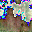

In [ ]:
#@title Display Generated GIF

from IPython.display import Image, display
import os
gif_filename = "generated_gif.gif"
if os.path.exists(gif_filename):
    print(f"Displaying {gif_filename}...")
    display(Image(filename=gif_filename))
else:
    print(f"ERROR: GIF file '{gif_filename}' not found.")
    print("Please ensure the generation step completed successfully and saved the file.")